# Seminar Software Composition Python Metrics tests

In [1]:
import pandas as pd
from tqdm.notebook import tqdm, trange
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ludo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
DATASET_FILE = 'class_comments_pharo.csv'

dataset = pd.read_csv(DATASET_FILE, header=None, names=['class', 'comment'])

dataset[:10]

,class,comment
0,AColorSelectorMorph,ColorComponentSelector showing an alpha gradie...
1,ASTCache,I am a simple cache for AST nodes correspondin...
2,ASTCacheReset,Announcement signaled to tell that the default...
3,ASTCacheResetTest,NaN
4,ASTEvaluationTest,I am testing AST evaluation
5,ASTPluginMeaningOfLife,A simple example for a AST transforming compil...
6,ASTTransformExamplePluginActive,This class changes the default compiler used t...
7,ASTTransformationPluginTest,NaN
8,ATraitedClass,Simple class to be traited in the tests
9,Abort,Notify to abort a task


## Dataset preparation

### Replace the NaN in the comments with empty string (IE empty comments)

In [3]:
df = dataset.copy()

df["comment"].fillna(" ", inplace=True)

print(f"Any null values left : {df.isnull().values.any()}")

Any null values left : False


## Comment length

### Preprocessing

In [4]:
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ludo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [60]:
def preprocess_comment(comment, stopwords):
    # split the comment text into lowercase words
    comment = nltk.word_tokenize(comment)        
    comment = [word.lower() for word in comment if word.isalnum()]
    

    # filter the stopwords and the punctuation
    try:
        comment = [word for word in comment if word not in stopwords]
    except:
        print(e)
    
    return comment

comments = df["comment"]
comments = [preprocess_comment(comment, stopwords=stopwords) for comment in comments]

### Computations

In [61]:
min_comment_len = 3
n_lower_length = 0

n_empty_comments = sum(map(lambda comment: 1 if len(comment) == 0 else 0, comments))
n_lower_length = sum(map(lambda comment: 1 if len(comment) < min_comment_len and len(comment) > 0 else 0, comments))

print(f"Total number of comments : {len(comments)}\n")
print(f"Number of empty comments : {n_empty_comments}")
print(f"Ratio of empty comments : {(n_empty_comments / len(comments))*100:.1f} %\n")

print(f"Number of comments with too few words (but not empty) : {n_lower_length}")
print(f"Ratio of comments too short : {(n_lower_length / len(comments))*100:.1f} %")

Total number of comments : 7863

Number of empty comments : 1541
Ratio of empty comments : 19.6 %

Number of comments with too few words (but not empty) : 196
Ratio of comments too short : 2.5 %


### Plots

In [74]:
import matplotlib.pyplot as plt
from statistics import mean

def plot_histogram(values, bins, title, xlabel, ylabel, yscale_val='linear', plot_average=False):
    plt.hist(values, bins=bins)
    plt.yscale(value=yscale_val)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if(plot_average):
        mean_val = mean(values)
        plt.axvline(mean_val, color='k', linestyle='dashed', linewidth=1)
        plt.min_ylim, max_ylim = plt.ylim()
        plt.text(mean_val*1.1, max_ylim*0.7, f"Avg : {mean_val:.2f}")
    plt.show()

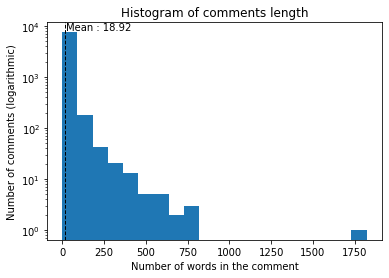

In [75]:
comments_len = list(map(lambda c: len(c), comments))
plot_histogram(comments_len, bins=20, yscale_val='log', title='Histogram of comments length',
                  ylabel='Number of comments (logarithmic)', xlabel='Number of words in the comment', plot_average=True)

## Analyzing language properties of comments

In [76]:
comments = df["comment"]

In [77]:
%%capture
from readcalc import readcalc

def get_gunning_fog(comment):
    calc = readcalc.ReadCalc(comment)
    return calc.get_gunning_fog_index()

def get_flesch_reading(comment):
    calc = readcalc.ReadCalc(comment)
    return calc.get_flesch_reading_ease()

def get_smog_index(comment):
    calc = readcalc.ReadCalc(comment)
    return calc.get_smog_index()


indices_functions = {
    'flesch_reading_ease':get_flesch_reading,
    'gunning_fog':get_gunning_fog,
    'smog_index':get_smog_index,
}

# init the dictionnary that will contain each index metric as key and the values for each comment as the values
indices_values = {}
for index_label in indices_functions.keys():
    indices_values[index_label] = []
    
for comment in comments:
    calc = readcalc.ReadCalc(comment)
    for index_label, index_func in indices_functions.items():
        val = index_func(comment)
        indices_values[index_label].append(val)

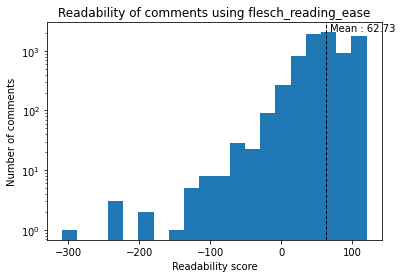

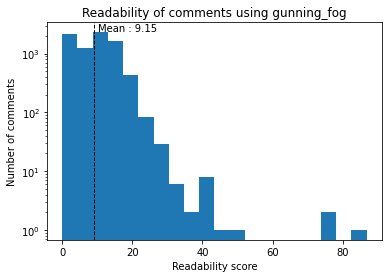

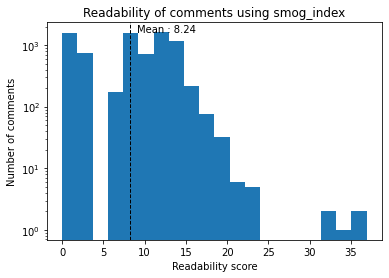

In [78]:
for label, values in indices_values.items():
    plot_histogram(values, bins=20, title=f"Readability of comments using {label}", 
                    yscale_val='log', 
                    ylabel='Number of comments (logarithmic)',
                    xlabel='Readability score',
                    plot_average=True)    

### Indices explained

#### Flesch reading ease

Higher is better.

[Source](https://yoast.com/flesch-reading-ease-score)
- 90-100	very easy to read, easily understood by an average 11-year-old student-
- 80-90	easy to read
- 70-80	fairly easy to read
- 60-70	easily understood by 13- to 15-year-old students
- 50-60	fairly difficult to read
- 30-50	difficult to read, best understood by college graduates
- 0-30	very difficult to read, best understood by university graduates

#### Gunning Fog

Lower is better.

[Source](https://en.wikipedia.org/wiki/Gunning_fog_index)
- 17	College graduate
- 16	College senior
- 15	College junior
- 14	College sophomore
- 13	College freshman
- 12	High school senior
- 11	High school junior
- 10	High school sophomore
- 9	High school freshman
- 8	Eighth grade
- 7	Seventh grade
- 6	Sixth grade

#### Smog index

[https://en.wikipedia.org/wiki/SMOG]
$grade = 1.043 \sqrt{number \; of \; polysyllables* \frac{30}{number\; of \;sentences}} + 3.1291$

Results can be interpreted using this [table](https://www.textcompare.org/readability/smog-index#Grade-Conversion)

#### Split the class into subwords WIP

In [79]:
print(df["class"][:10])

0                AColorSelectorMorph
1                           ASTCache
2                      ASTCacheReset
3                  ASTCacheResetTest
4                  ASTEvaluationTest
5             ASTPluginMeaningOfLife
6    ASTTransformExamplePluginActive
7        ASTTransformationPluginTest
8                      ATraitedClass
9                              Abort
Name: class, dtype: object
